 # GCM Filters and Numerical Instability
 
The filtering scheme used in GCM Filters may become unstable and lead to wrong answers in case of filtering data over a wide range of scales. In this case, a combination of GCM filters and data coarsening would be more appropriate to maintain accuracy. 

For the purpose of demonstration, we employ output from a global MOM6 simulation having a spatial resolution of $1/4^{\circ}$ to perform a combination of spatial filtering and corsening to obtain desired output.

In [1]:
import xarray as xr
import requests
import numpy as np
import gcm_filters
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
# Functions for plotting

def plot_map(ax, da, vmin=-999, vmax=999,
             lon='geolon', lat='geolat', cmap='RdBu_r', title='what is it?'):
    
    p = da.plot(ax=ax, x=lon, y=lat, vmin=vmin, vmax=vmax, cmap=cmap, 
                transform=ccrs.PlateCarree(), add_labels=False, add_colorbar=False)
    
    # add separate colorbar
    cb = plt.colorbar(p, ax=ax, extend='both', orientation="horizontal", shrink=0.6)
    cb.ax.tick_params(labelsize=12)

    p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
    
    _ = plt.title(title, fontsize=14)
    return fig

### Filtering

We filter the vorticity field to $2^{\circ}$ and $10^{\circ}$ resolutions. For this, we first create the filter objects for filtering the data by fixed scale factors of 8 and 40. We then compare the filtered data to the original data. The test data can be found [here](https://figshare.com/articles/dataset/Ocean_Surface_velocities_from_a_global_ocean_simulation/14575356). 

In [3]:
url = 'https://ndownloader.figshare.com/files/27968028'
file1 = requests.get(url)
open('data.nc', 'wb').write(file1.content)

ds = xr.open_dataset("data.nc")

print(ds)

<xarray.Dataset>
Dimensions:       (xh: 1440, xq: 1440, yh: 1080, yq: 1080)
Coordinates:
    time          object ...
  * xh            (xh) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * yh            (yh) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
  * xq            (xq) float64 -299.6 -299.3 -299.1 -298.9 ... 59.66 59.91 60.16
  * yq            (yq) float64 -80.35 -80.27 -80.19 -80.11 ... 89.78 89.89 90.0
Data variables: (12/30)
    ssu           (yh, xq) float32 ...
    ssv           (yq, xh) float32 ...
    zos           (yh, xh) float32 ...
    Coriolis      (yq, xq) float32 ...
    areacello     (yh, xh) float32 ...
    areacello_bu  (yq, xq) float32 ...
    ...            ...
    sftof         (yh, xh) float32 ...
    wet           (yh, xh) float32 ...
    wet_c         (yq, xq) float32 ...
    wet_u         (yh, xq) float32 ...
    wet_v         (yq, xh) float32 ...
    zeta          (yq, xq) float32 ...


In [4]:
# Filtering test

area = ds['areacello_bu']
wet_mask = ds['wet_c']

filter_2Deg = gcm_filters.Filter(filter_scale=8, dx_min=1, filter_shape=gcm_filters.FilterShape.GAUSSIAN,
                              grid_type=gcm_filters.GridType.REGULAR_WITH_LAND,grid_vars={'wet_mask': wet_mask})

filter_10Deg = gcm_filters.Filter(filter_scale=40, dx_min=1, filter_shape=gcm_filters.FilterShape.GAUSSIAN,
                              grid_type=gcm_filters.GridType.REGULAR_WITH_LAND,grid_vars={'wet_mask': wet_mask})

zeta_2Deg = filter_2Deg.apply(ds['zeta'] * area, dims=['yq', 'xq'])
%time zeta_2Deg = (zeta_2Deg/area).load()

zeta_10Deg = filter_10Deg.apply(ds['zeta'] * area, dims=['yq', 'xq'])
%time zeta_10Deg = (zeta_10Deg/area).load()

CPU times: user 24 ms, sys: 0 ns, total: 24 ms
Wall time: 23.5 ms
CPU times: user 23 ms, sys: 0 ns, total: 23 ms
Wall time: 22.8 ms


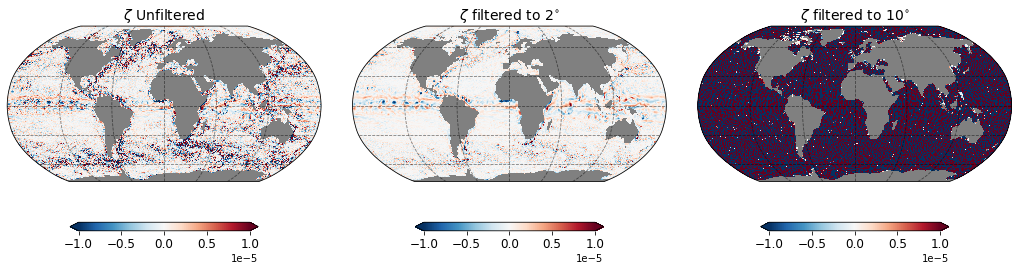

In [5]:
max_z = 1.e-5

grid1 = plt.GridSpec(1, 3, wspace=0.1, hspace=0.1)
fig = plt.figure(figsize=[18,5])

tmp = ds['zeta'].assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})
ax = fig.add_subplot(grid1[0, 0], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, tmp, vmin=-max_z, vmax=max_z, 
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\zeta$ Unfiltered')

tmp = zeta_2Deg.assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})
ax = fig.add_subplot(grid1[0, 1], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, tmp, vmin=-max_z, vmax=max_z, 
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\zeta$ filtered to $2^{\circ}$')

tmp = zeta_10Deg.assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})
ax = fig.add_subplot(grid1[0, 2], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, tmp, vmin=-max_z, vmax=max_z, 
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\zeta$ filtered to $10^{\circ}$')

### Data Coarsening and Filtering 

From the figure above, numerical instability leads to large errors when an attempt is made to filter the data to $10^{\circ}$ resolution. In order to overcome this issue, we can first interpolate the data from $1/4^{\circ}$ to a coarser grid and then filter the coarsened data to $10^{\circ}$ resolution.

As shown below, we first coarsen the data by taking mean over consecutive four gridpoints and then filter data to $10^{\circ}$ resolution (note that scale factor is 10 in this case). This is only for demostration and, in practice, more advanced coarsening methods can be empoyed. Note that scale factor is 10 in this case. We then interpolate the filtered data back to the original finer grid. With this approach, the numerical instability issue does not seem to appear anymore.

In [6]:
cor_fac = 4

zeta_coarse = zeta_2Deg.coarsen(xq=cor_fac, yq=cor_fac, boundary="trim", keep_attrs=True).mean()
area = ds['areacello_bu'].coarsen(xq=cor_fac, yq=cor_fac, boundary="trim", keep_attrs=True).sum()
wet_mask = ds['wet_c'].coarsen(xq=cor_fac, yq=cor_fac, boundary="trim", keep_attrs=True).max()

filter_cor = gcm_filters.Filter(filter_scale=10, dx_min=1, filter_shape=gcm_filters.FilterShape.GAUSSIAN,
                              grid_type=gcm_filters.GridType.REGULAR_WITH_LAND,grid_vars={'wet_mask': wet_mask})

zeta_10Deg_cor = filter_cor.apply(zeta_coarse * area, dims=['yq', 'xq'])

%time zeta_10Deg_cor = (zeta_10Deg_cor/area).load()

zeta_10Deg_cor = zeta_10Deg_cor.interp(xq=ds['xq'], yq=ds['yq'])

CPU times: user 3 ms, sys: 0 ns, total: 3 ms
Wall time: 3.07 ms


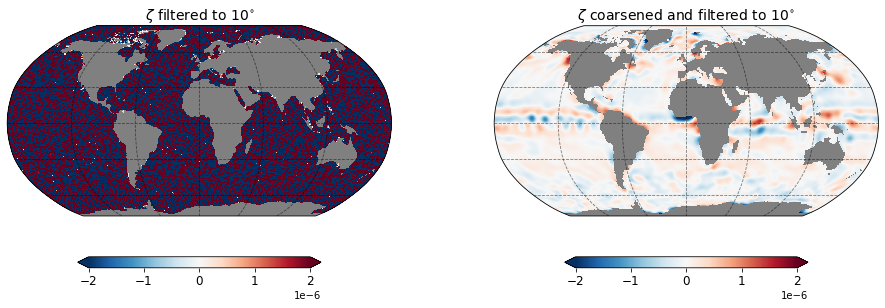

In [7]:
max_z = 0.2e-5

grid1 = plt.GridSpec(1, 2, wspace=0.2, hspace=0.2)
fig = plt.figure(figsize=[16,5])

tmp = zeta_10Deg.assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})
ax = fig.add_subplot(grid1[0, 0], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, tmp, vmin=-max_z, vmax=max_z, 
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\zeta$ filtered to $10^{\circ}$')

tmp = zeta_10Deg_cor.assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})
ax = fig.add_subplot(grid1[0, 1], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, tmp, vmin=-max_z, vmax=max_z, 
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\zeta$ coarsened and filtered to $10^{\circ}$')

### Filtering with Double Precision Data

Filtering accuracy can also be improved by enforcing computations in double precision. Below, we create dataset `ds2` from `ds` and the new dataset `ds2` has double precision, i.e. `np.float64`. By ensuring computations in double precision, we are able to filter vorticity to $10^{\circ}$ resolution without data coarsening.

In [8]:
ds2 = ds.astype(np.float64)

area = ds2['areacello_bu']
wet_mask = ds2['wet_c']

filter_10Deg = gcm_filters.Filter(filter_scale=40, dx_min=1, filter_shape=gcm_filters.FilterShape.GAUSSIAN,
                              grid_type=gcm_filters.GridType.REGULAR_WITH_LAND,grid_vars={'wet_mask': wet_mask})

zeta_10Deg = filter_10Deg.apply(ds2['zeta'] * area, dims=['yq', 'xq'])
%time zeta_10Deg = (zeta_10Deg/area).load()

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 7.37 ms


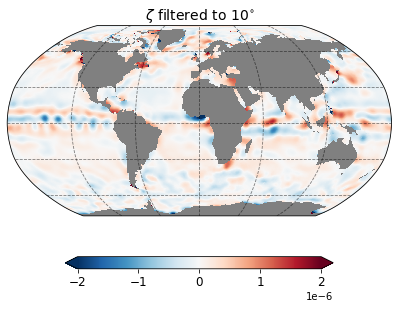

In [9]:
max_z = 0.2e-5

grid1 = plt.GridSpec(1, 1, wspace=0.2, hspace=0.2)
fig = plt.figure(figsize=[8,5])

tmp = zeta_10Deg.assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})
ax = fig.add_subplot(grid1[0, 0], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, tmp, vmin=-max_z, vmax=max_z, 
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'$\zeta$ filtered to $10^{\circ}$')